In [1]:
# Import all the packages
import pystan
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy.stats.stats import pearsonr

In [225]:
# Data
df = pd.read_csv("/Users/ritakurban/Downloads/lba_dat.csv")
# Convert everyhing to lower case
df = df.apply(lambda x: x.astype(str).str.lower())
df.columns = map(str.lower, df.columns)
# Drop columns that aren't used in the model
df = df.drop(["your name","timestamp", "email address", "Grocery store street address"], axis=1)

In [226]:
# Rearrange the df so that we only have 5 columns (including the type of product)
res = pd.concat([df.iloc[:,0:2], df.iloc[:,2:4] ], axis=1, join='inner')
res.columns =['store', 'neighborhood', 'brand', 'price']

for i in range(4, 62,2):
    data = pd.concat([df.iloc[:,0:2], df.iloc[:,i:(i+2)] ], axis=1, join='inner')
    data.columns =['store', 'neighborhood', 'brand', 'price']
    res = pd.concat([res, data], axis=0, join='outer', ignore_index=False,
           keys=None, levels=None, names=None, verify_integrity=False,
           copy=True)

    # Add the product column
prod = ["apples"]*240+["bananas"]*240+["tomatoes"]*240+["potatoes"]*240+["flour"]*240+["rice"]*240+["milk"]*240+["butter"]*240+["eggs"]*240+["chicken"]*240
prod
res["product"]=prod


In [227]:
# Calculate average price of products
count = 0
summa = 0
avg_prices = []
for i in range(0, 2400, 240):
    current_product = res.price[i:(i+240)].tolist()
    for j in range(len(current_product)):
        if current_product[j] != "nan":
            count +=1
            summa += float(current_product[j])
    average = summa/count
    summa = 0
    count = 0
    avg_prices.append(average)
    
products=["Apples", "Bananas","Tomatoes", "Potatoes", "Flour","Rice", "Milk", "Butter","Eggs", "Chicken"]
mean_p =pd.DataFrame(products)
mean_p['price'] = avg_prices
mean_p.columns =['Product','Average Price']
mean_p = mean_p.sort_values(by='Product')
mean_p

,Product,Average Price
0,Apples,2.282711
1,Bananas,1.431739
7,Butter,4.077870
9,Chicken,9.845563
8,Eggs,2.574876
4,Flour,1.064358
6,Milk,1.045189
3,Potatoes,1.352609
5,Rice,2.338808
2,Tomatoes,3.436967


In [229]:
# Delete rows that don't contail any price values
res = res[res['price'] != "nan"]
# Delete rows that are not in Berlin
res = res[res['neighborhood'] != "other"]


1678

In [230]:
# Label Encoder to convert categorical variables to integers
from sklearn import preprocessing
lp = preprocessing.LabelEncoder()
ln = preprocessing.LabelEncoder()
lb = preprocessing.LabelEncoder()
ls = preprocessing.LabelEncoder()

res['product'] = lp.fit_transform(res["product"])
res['product'] = [x+1 for x in res['product']]
res['neighborhood'] = ln.fit_transform(res["neighborhood"])
res['neighborhood'] = [x+1 for x in res['neighborhood']]
res['brand'] = lb.fit_transform(res["brand"])
res['brand'] = [x+1 for x in res['brand']]
res['store'] = ls.fit_transform(res["store"])
res['store'] = [x+1 for x in res['store']]

res.head()

,store,neighborhood,brand,price,product
0,3,5,534,2.49,1
1,3,5,534,2.49,1
2,1,8,311,2.72,1
3,2,5,534,1.99,1
4,2,3,342,1.99,1


In [324]:
# Convert str to float
pr = res.price.tolist()
price = [float(x) for x in pr]

# Data in a stan format
stan_data = {
    'alpha': 9,  # fixed prior hyperparameters
    'beta': 8, 
    'l': 2, 
    's': 5, 
    'sigma': 0.1,# normal distribution
    'product': res['product'].tolist(), # list of products
    'store': res['store'].tolist(), # list of stores
    'neighborhood': res['neighborhood'].tolist(),# list of neighborhoods
    'brand': res['brand'].tolist(), #list of brands
    'price': price, # list of prices
    'N': len(res), # number of observaions
    'N_brand': len(lb.classes_), # number of brands
    'N_prod': len(lp.classes_), # number of products
    'N_neigh': len(ln.classes_), # number of neighborhoods
    'N_store': len(ls.classes_) # number of stores
    }

In [205]:
# Stan Model
stan_code = """

data {  
    int < lower = 1 > N; // Number of observations
    int < lower = 1 > N_store; // Number of stores
    int < lower = 1 > N_neigh; // Number of neighborhoods
    int < lower = 1 > N_prod; // Number of products
    int < lower = 1 > N_brand; // Number of brands
    real<lower=0> price[N]; //observed price of each product 
    int<lower=0> store[N]; //type of store
    int<lower=0> product[N]; //product type
    int<lower=0> neighborhood[N]; //neighborhood
    int<lower=0> brand[N]; //brand
    
    real<lower=0> alpha;   // fixed prior hyperparameters for Cauchy, gamma, and normal
    real<lower=0> beta;   // 
    real<lower=0> sigma; // 
    real<lower=0> s;   // 
    real<lower=0> l;   // 
}

parameters {
    real <lower=0> base_price[N_prod]; // mutipliers for each store, brand, and neighborhood + base prices
    real <lower=0> st[N_store]; //
    real <lower=0> neigh[N_neigh]; //
    real <lower=0> br[N_brand]; //
    
}

model {
    base_price ~ cauchy(l, s); // Cauchy prior on base price that can be scaled to other currencies
    st ~ gamma(alpha, beta); // Beta prior on multipliers
    neigh ~ gamma(alpha, beta);
    br ~ gamma(alpha, beta);
    for (i in 1:N) {
        price[i] ~ normal(base_price[product[i]]*st[store[i]]*neigh[neighborhood[i]]*br[brand[i]], sigma);  // normal likelihood function
    }
}

"""

In [206]:
# Compiling a Stan model 
stan = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_82fbcbf8f8b3da29e4c28f2a28aafd4d NOW.


In [232]:
# Get samples
full_res = stan.sampling(data=stan_data)

In [233]:
print full_res

Inference for Stan model: anon_model_82fbcbf8f8b3da29e4c28f2a28aafd4d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.



In [234]:
# Base and average price comparison
posterior_samples = full_res.extract()
mean_p["Base Price"] = posterior_samples["base_price"].mean(axis=0)
mean_p

,Product,Average Price,Base Price
0,Apples,2.282711,2.320302
1,Bananas,1.431739,1.474612
7,Butter,4.077870,4.713260
9,Chicken,9.845563,17.061648
8,Eggs,2.574876,3.381703
4,Flour,1.064358,1.056122
6,Milk,1.045189,1.037010
3,Potatoes,1.352609,1.308455
5,Rice,2.338808,2.440597
2,Tomatoes,3.436967,3.452220


In [320]:
# Store multiplier
store_mult = pd.DataFrame(ls.classes_)
store_mult['multiplier'] = posterior_samples["st"].mean(axis=0)
store_mult.columns = ['Store', 'Multiplier']
store_mult

/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Store,Multiplier
0,aldi,1.103302
1,edeka,0.850347
2,lidl,0.811144
3,rewe,0.929646


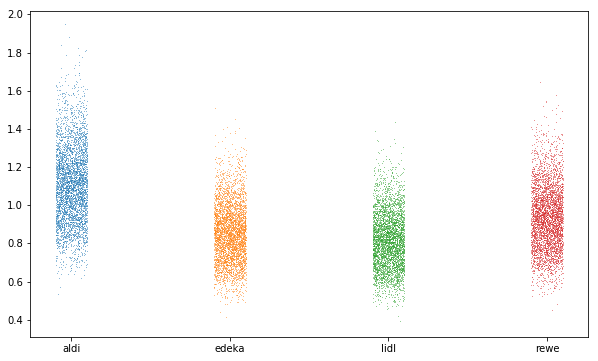

In [322]:
# Plot store samples
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=posterior_samples['st'].shape[0]), posterior_samples['st'][:,i], ',', alpha=0.5)
plt.xticks(range(1, len(ls.classes_)+1), ls.classes_)
plt.show()

In [236]:
# Neighborhood multipliers
neigh_mult = pd.DataFrame(ln.classes_)
neigh_mult['multiplier'] = posterior_samples["neigh"].mean(axis=0)
neigh_mult.columns = ['Neighborhood', 'Multiplier']
neigh_mult

,Neighborhood,Multiplier
0,alt-treptow,0.964826
1,friedrichshain,1.080026
2,kreuzberg,1.065152
3,lichtenberg,0.954068
4,mitte,1.063220
5,neukoelln,0.847655
6,prenzlauer berg,0.915700
7,schoeneberg,1.094441
8,tempelhof,1.332327


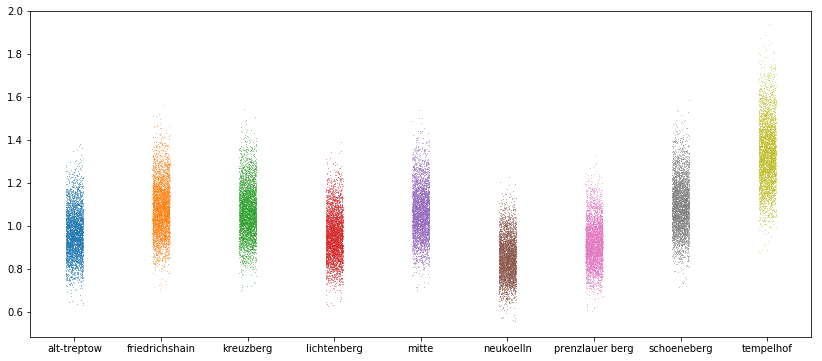

In [323]:
# Plot neighborhood samples
plt.figure(figsize=(14, 6))
for i in range(9):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=posterior_samples['neigh'].shape[0]), posterior_samples['neigh'][:,i], ',', alpha=0.5)
plt.xticks(range(1, len(ln.classes_)+1), ln.classes_)
plt.show()

In [270]:
# Compare rent prices and multipliers
neighborhoods = ['Prenzlauer Berg',  'Mitte','Tempelhof','Friedrichshain','Alt-Treptow','Lichtenberg','Neukoelln','Kreuzberg','Schoeneberg']
rent_prices = [865,1044,743,649,794, 739,812,863,797]
multipliers = posterior_samples["neigh"].mean(axis=0)
neigh_prices = pd.DataFrame(neighborhoods)
neigh_prices['Prices'] = rent_prices
neigh_prices.columns = ['Neighborhood', 'Rent Price']
neigh_prices = neigh_prices.sort_values(by='Neighborhood')
neigh_prices['Multiplier'] = multipliers
neigh_prices

,Neighborhood,Rent Price,Multiplier
4,Alt-Treptow,794,0.964826
3,Friedrichshain,649,1.080026
7,Kreuzberg,863,1.065152
5,Lichtenberg,739,0.954068
1,Mitte,1044,1.063220
6,Neukoelln,812,0.847655
0,Prenzlauer Berg,865,0.915700
8,Schoeneberg,797,1.094441
2,Tempelhof,743,1.332327


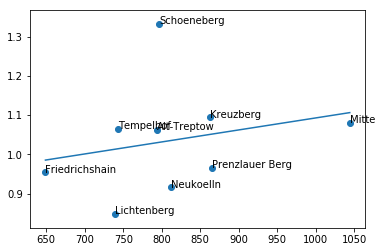

0.24078171709160334


In [271]:
# Scatter plot for rent and grocery prices
fig, ax = plt.subplots()
ax.scatter(rent_prices, multipliers)

for i, txt in enumerate(neighborhoods):
    ax.annotate(txt, (rent_prices[i], multipliers[i]))

plt.plot(np.unique(rent_prices), np.poly1d(np.polyfit(rent_prices, multipliers, 1))(np.unique(rent_prices)))
plt.show()

# Calculate Pearson's R
print pearsonr(rent_prices,multipliers)[0]

In [289]:
# Brand multiplier values
print "Minimum Value of the Multiplier = ", posterior_samples["br"].mean(axis=0).min(axis=0)
print "Mean Value of the Multiplier = ",posterior_samples["br"].mean(axis=0).mean(axis=0)
print "Maximum Value of the Multiplier = ", posterior_samples["br"].mean(axis=0).max(axis=0)



Minimum Value of the Multiplier =  0.01432202233766675
Mean Value of the Multiplier =  1.1243190437063384
Maximum Value of the Multiplier =  8.641482011793387


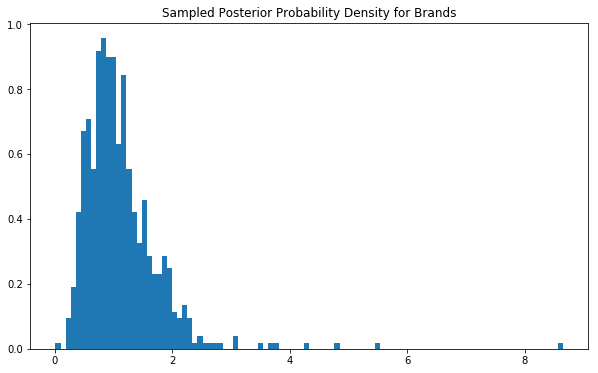

In [290]:
# Plot brand multiplier distribution
plt.figure(figsize=(10, 6))
plt.hist(posterior_samples['br'].mean(axis=0), bins=100, density=True)
plt.title('Sampled Posterior Probability Density for Brands')

plt.show()